<a href="https://colab.research.google.com/github/Steelcrawler/PioneerResearchCode/blob/main/Pioneer_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
!pip install qiskit
import qiskit
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from qiskit.providers.ibmq import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.ibmq import *
IBMQ.save_account('81bd918397fb0ea9b1a61580e89ca11d8771ae812d6c608b218ff48446de20b5833c6ad93d992419b9dd015d3366ea84fc44bb5bcd77b7b4348ff5b48dc2f3af', overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (2+1) and
#     not x.configuration().simulator and x.status().operational==True))
backend1 = provider.backend.ibmq_lima
print(backend1)
noise_model = NoiseModel.from_backend(backend1)

# Get coupling map from backend
coupling_map = backend1.configuration().coupling_map
print(type(noise_model))
# Get basis gates from noise model
#basis_gates = noise_model.basis_gates

backend = AerSimulator(noise_model=noise_model)

ibmq_lima
<class 'qiskit.providers.aer.noise.noise_model.NoiseModel'>


In [ ]:
import qiskit.providers.aer.noise
props = backend1.properties()
print(type(backend))
print(props.gate_error('sx', 0))
print(props.t1(0))
print(props.readout_error(0))
print(props.gate_error('sx', 1))
print(props.t1(1))
print(props.readout_error(1))
#t1 = relaxation, sx, gate_error

<class 'qiskit.providers.aer.backends.aer_simulator.AerSimulator'>
0.0005431213071607136
8.338175326476496e-05
0.01990000000000003
0.0004981163801048794
9.336171946454742e-05
0.011199999999999988


In [ ]:
import qiskit.providers.aer.noise as noise
prob_1 = 0.2  # 1-qubit gate
prob_2 = 0.2   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

middlenoise = noise.NoiseModel()
middlenoise.add_all_qubit_quantum_error(error_1, ['id', 'rz', 'sx', 'x'])
middlenoise.add_all_qubit_quantum_error(error_2, ['cx'])

backend = AerSimulator(noise_model=middlenoise)

In [ ]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)

        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)

        return np.array([expectation])

In [ ]:
# import qiskit.providers.aer.noise as noise
# prob_1 = 2.838*(10**-3) # 1-qubit gate
# prob_2 = 2.838*(10**-3)  # 2-qubit gate

# # Depolarizing quantum errors
# error_1 = noise.depolarizing_error(prob_1, 1)
# error_2 = noise.depolarizing_error(prob_2, 2)

# # Add errors to noise model
# noise_model = noise.NoiseModel()
# noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
# noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

In [ ]:
# provider = IBMQ.get_provider(hub='ibm-q')
# #backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (2+1) and
# #    not x.configuration().simulator and x.status().operational==True))
# backend = AerSimulator(noise_model=noise_model)
# print(backend)

circuit = QuantumCircuit(1, backend, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.35


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
n_samples = 100

X_train = datasets.KMNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
#Returns (image, target) where target is index of the target class. Return type tuple
print(np.where(X_train.targets == 0)[0])
#np.where(X_train.targets == 0) returns tuple of all values where targets = 0 in the form of a tuple, with the first index being the array used
#np.where(X_train.targets == 0)[0] returns numpy array of all the integers where targets == 0
#np.where(X_train.targets == 0)[0][:n_samples] gets the first n_sample indexes where the targets == 0

#eaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
print(X_train)
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

[    2    12    29 ... 59964 59966 59997]
Dataset KMNIST
    Number of datapoints: 200
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


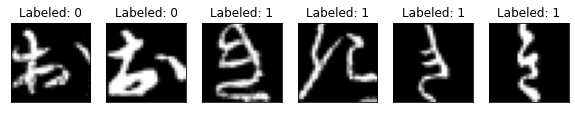

In [ ]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

In [ ]:
n_samples = 100

X_test = datasets.KMNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(backend, 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


Training [10%]	Loss: -0.5500
Training [20%]	Loss: -0.5647
Training [30%]	Loss: -0.5835
Training [40%]	Loss: -0.5823
Training [50%]	Loss: -0.5812
Training [60%]	Loss: -0.5811
Training [70%]	Loss: -0.5869
Training [80%]	Loss: -0.5909
Training [90%]	Loss: -0.5956
Training [100%]	Loss: -0.5903


In [ ]:
model.eval()
with torch.no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.5930
	Accuracy: 94.5%


In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


Training [10%]	Loss: -0.4995
Training [20%]	Loss: -0.4995
Training [30%]	Loss: -0.5052
Training [40%]	Loss: -0.4996
Training [50%]	Loss: -0.4966
Training [60%]	Loss: -0.5028
Training [70%]	Loss: -0.5043
Training [80%]	Loss: -0.4993
Training [90%]	Loss: -0.5014
Training [100%]	Loss: -0.5034


In [ ]:
model.eval()
with torch.no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.5028
	Accuracy: 45.0%


In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


Training [10%]	Loss: -0.5048
Training [20%]	Loss: -0.4999
Training [30%]	Loss: -0.4978
Training [40%]	Loss: -0.5039
Training [50%]	Loss: -0.4968
Training [60%]	Loss: -0.4958
Training [70%]	Loss: -0.4985
Training [80%]	Loss: -0.5005
Training [90%]	Loss: -0.4985
Training [100%]	Loss: -0.4927


In [ ]:
model.eval()
with torch.no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4967
	Accuracy: 56.0%


Text(0, 0.5, 'Neg Log Likelihood Loss')

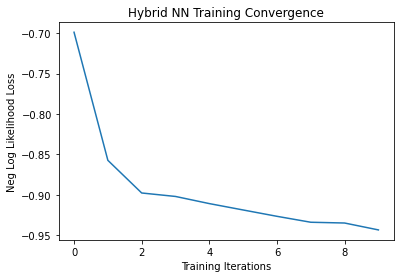

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.9408
	Accuracy: 100.0%


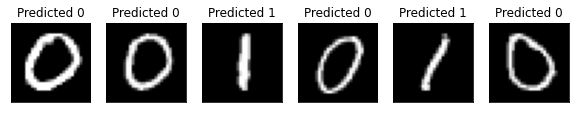

In [ ]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))

        count += 1

In [ ]:
qc = QuantumCircuit(1)
qc.h(0)
qc.x(0)
qc.z(0)
qc.h(0)
qc.draw()

TypeError: ignored

In [ ]:
svsim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = assemble(qc)
final_state = svsim.run(qobj).result().get_statevector()
array_to_latex(final_state, prefix ="\\text{Statevector = }")

<IPython.core.display.Latex object>

In [ ]:
qc2 = QuantumCircuit(7)

In [ ]:
qc.cx(0, 1)
qc.draw()

┌───┐┌───┐┌───┐┌───┐     
q_0: ┤ H ├┤ Z ├┤ X ├┤ H ├──■──
     └───┘└───┘└───┘└───┘┌─┴─┐
q_1: ────────────────────┤ X ├
                         └───┘